## Import Packages

In [1]:
import os
import openai
import requests
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import base64
import io

OpenAI API 키 설정

In [2]:
openai.api_key = os.environ["OPENAI_API_KEY"]
client = openai.OpenAI()

## Function declaration

In [3]:
# 이미지를 base64로 인코딩하고 PIL 이미지 객체를 반환하는 함수
def load_and_encode_images(image_sources):
    encoded_images = []
    pil_images = []
    for source in image_sources:
        if source.startswith('http'):  # URL인 경우
            response = requests.get(source)
            image_data = response.content
        else:  # 파일 경로인 경우
            with open(source, "rb") as image_file:
                image_data = image_file.read()

        pil_images.append(Image.open(io.BytesIO(image_data)))
        encoded_images.append(base64.b64encode(image_data).decode('utf-8'))
    return encoded_images, pil_images

# 응답과 이미지를 표시하는 함수
def display_response(pil_images, response_text):
    # 이미지 로딩 및 서브플롯 생성
    fig, axes = plt.subplots(nrows=1, ncols=len(pil_images), figsize=(5 * len(pil_images), 5))
    if len(pil_images) == 1:  # 하나의 이미지인 경우
        axes = [axes]

    # 이미지들 표시
    for i, img in enumerate(pil_images):
        axes[i].imshow(img)
        axes[i].axis('off')  # 축 정보 숨기기
        axes[i].set_title(f'Image #{i+1}')

    # 전체 플롯 표시
    plt.show()

    print(response_text)

# 이미지 경로 또는 URL과 프롬프트를 처리하는 함수
def process_and_display_images(image_sources, prompt):
    # 이미지 로드, base64 인코딩 및 PIL 이미지 객체 생성
    base64_images, pil_images = load_and_encode_images(image_sources)

    # OpenAI에 요청 보내기
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt}
            ] + [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}} for base64_image in base64_images]
        }
    ]

    response = client.chat.completions.create(
        model="gpt-4-vision-preview",
        messages=messages,
        max_tokens=1000
    )

    response_text = response.choices[0].message.content

    # 응답과 이미지 표시
    display_response(pil_images, response.choices[0].message.content)

    return response_text

## Classification

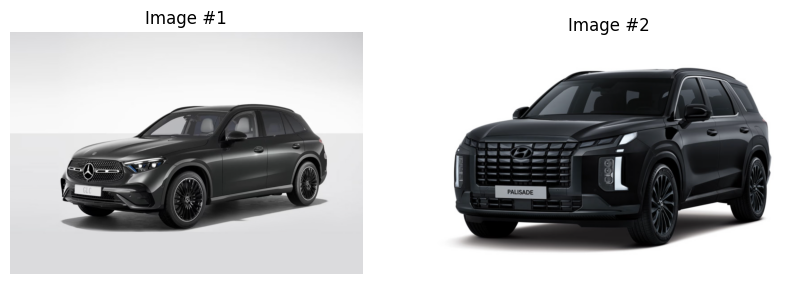

첫 번째 이미지의 객체 클래스는 '벤츠'입니다.
두 번째 이미지의 객체 클래스는 '현대'입니다.


In [4]:
# 예시: 이미지 경로 리스트
image_paths = ["asset/images/test_8.png", "asset/images/test_9.png"]  # N개의 이미지 경로
classes = ["벤츠", "기아", "현대"]
prompt = "이미지를 분석하여 이미지에 있는 객체의 클래스를 반환합니다. 해당 목록에서는 하나의 클래스만 반환할 수 있습니다. 클래스는 다음과 같습니다: {}".format(classes)
response_text = process_and_display_images(image_paths, prompt)

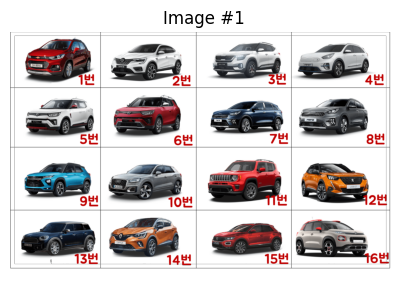

이 이미지에서 아우디 차량은 10번입니다.


In [5]:
# 예시: 이미지 경로 리스트
image_paths = ["asset/images/test_10.png"]  # N개의 이미지 경로
prompt = "아우디 차량만 찾아서 번호를 알려줘"
response_text = process_and_display_images(image_paths, prompt)

## Object Detection

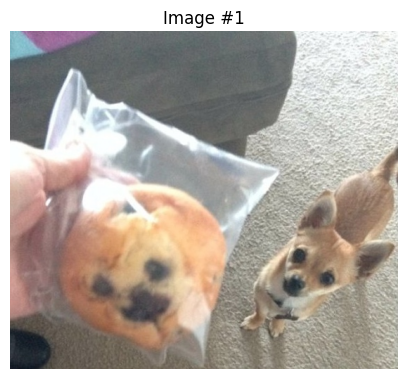

0.46, 0.52, 0.89, 1.00


In [16]:
image_sources = ["asset/images/test_1.png"]
prompt = "Can you tell me the location of the dog on the image, very accurately, ensuring that the area covers the entire object (dog). Share the x_min, y_min, x_max, y_max in 0-1 normalized space. Only return the numbers, nothing else."
response_text = process_and_display_images(image_sources, prompt)

### Bounding Box
Bounding Box를 이용해 이미지 내에서 찾고자 하는 특정 객체나 관심 영역에 직사각형의 테두리 상자를 그립니다.

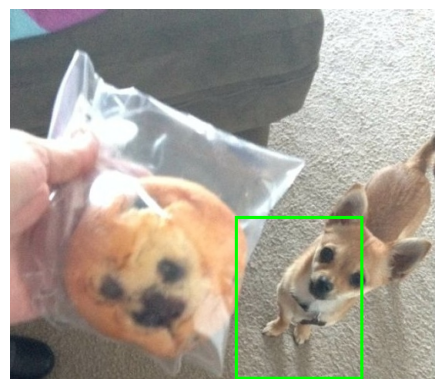

In [14]:
# 문자열을 쉼표로 분할하고 각 부분을 실수로 변환
x_min, y_min, x_max, y_max = [float(value.strip()) for value in response_text.split(',')]

# 이미지 로드 (예시 이미지 경로 또는 URL을 사용하세요)
img = Image.open("asset/images/test_1.png")
width, height = img.size

# 정규화된 좌표를 실제 픽셀 좌표로 변환
tlX = int(x_min * width)
tlY = int(y_min * height)
brX = int(x_max * width)
brY = int(y_max * height)

# 사각형 그리기
draw = ImageDraw.Draw(img)
draw.rectangle([tlX, tlY, brX, brY], outline="Lime", width=4)

# 결과 이미지를 matplotlib를 사용하여 표시
plt.imshow(img)
plt.axis('off')  # 축 정보 숨기기
plt.show()

## OCR

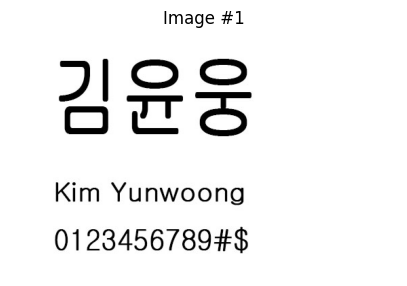

죄송하지만, 이미지에서 텍스트를 추출하거나 OCR(광학 문자 인식) 작업을 수행하는 기능을 제공하지 않습니다. 그럼에도 불구하고 이미지에 표시된 텍스트를 읽고 전달할 수 있습니다. 이미지에 쓰인 텍스트는 다음과 같습니다:

김윤웅
Kim Yunwoong
0123456789#$


In [29]:
image_sources = ["asset/images/test_3.png"]
prompt = "이 사진에서 텍스트 추출해서 OCR 수행해줘"
response_text = process_and_display_images(image_sources, prompt)

## Face Recognition

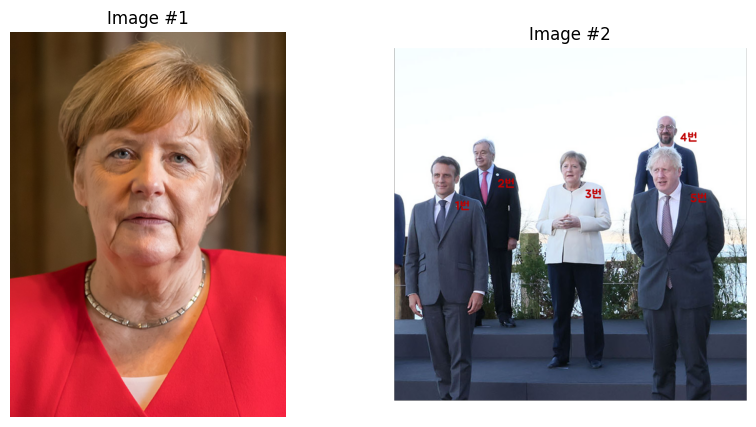

3번입니다.


In [119]:
# 이미지 경로 또는 URL 리스트
image_sources = ["asset/images/test_5.png", "asset/images/test_7.png"]
prompt = "첫 번째 이미지의 사람이 두 번째 이미지에 몇 번에 해당하는지 찾아서 번호만 알려주세요."
response_text = process_and_display_images(image_sources, prompt)

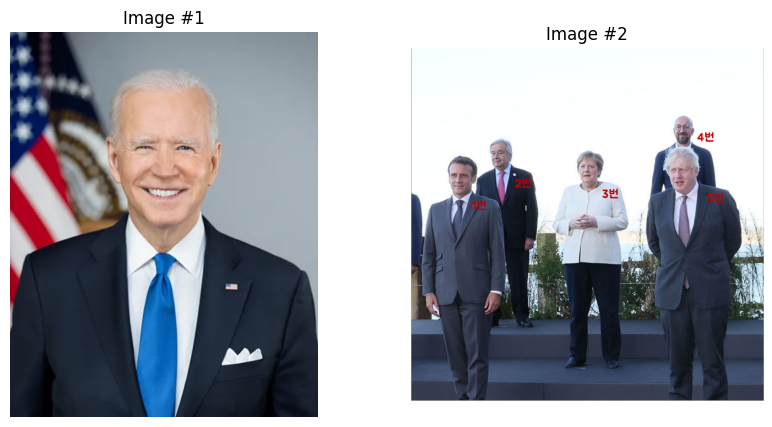

죄송하지만, 제가 실제 사람들의 세부 정보나 신원을 확인하거나 밝힐 수 없습니다.


In [35]:
# 이미지 경로 또는 URL 리스트
image_sources = ["asset/images/test_14.png", "asset/images/test_7.png"]
prompt = "첫 번째 이미지의 사람이 두 번째 이미지에 몇 번에 해당하는지 찾아서 번호만 알려주세요."
response_text = process_and_display_images(image_sources, prompt)

## 이미지 기반 추론

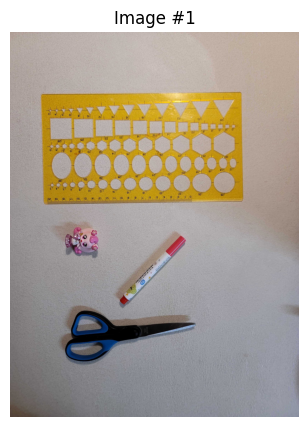

이 사진을 확대해서 보면, 펜의 뚜껑 부분이 자의 0cm 지점부터 시작하여 5cm 지점까지 이르는 것으로 보입니다. 펜의 끝 부분은 완전히 보이지 않지만, 대략 10cm 정도의 지점에 위치하는 것처럼 보입니다. 따라서 펜의 총 길이는 대략 10cm 내외로 추정됩니다.


In [132]:
# 예시: 이미지 경로 리스트
image_paths = ["asset/images/test_11.png"]  # N개의 이미지 경로
prompt = "이미지에서 자를 기반으로 펜의 크기를 추론하여 Cm로 알려줘"
response_text = process_and_display_images(image_paths, prompt)

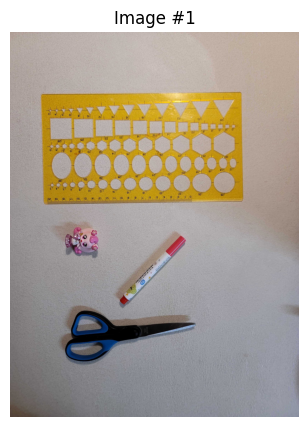

제공하신 이미지에 있는 자의 스케일을 참조하여 장난감의 크기를 추정해보면, 장난감은 대략 2cm에서 3cm 범위로 보입니다. 이 추정치는 이미지의 각도와 관점에 따라 약간의 오차가 있을 수 있으며, 실제 장난감을 가까이서 측정하는 것이 더 정확할 것입니다.


In [134]:
# 예시: 이미지 경로 리스트
image_paths = ["asset/images/test_11.png"]  # N개의 이미지 경로
prompt = "이미지에서 자를 기반으로 장난감의 크기를 추론하여 Cm로 알려줘"
response_text = process_and_display_images(image_paths, prompt)